In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D, AveragePooling2D,Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels

import rasterio
from rasterio.plot import reshape_as_image

#from keras_efficientnets import EfficientNetB0

General Methods

In [2]:
#simple CSV loader
def load_samples(csv_file):
    data = pd.read_csv(os.path.join(csv_file))
    data = data[['FileName','Label','ClassName']]
    file_names = list(data.iloc[:,0])
    #Get labels withing second column
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

#helper function to report  a images details
def image_details(image):
  num_bands = img_dataset.count
  print('Number of bands in image: {n}\n'.format(n=num_bands))

  # How many rows and columns?
  rows, cols = img_dataset.shape
  print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

  # What driver was used to open the raster?
  driver = img_dataset.driver
  print('Raster driver: {d}\n'.format(d=driver))

  # What is the raster's projection?
  proj = img_dataset.crs
  print('Image projection:')
  print(proj)

def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,model_name='test'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #save a copy of the classification matrix
    fig.savefig('classification_matrix_' + model_name + '.png')
    return ax

def save_metrics(gridsearch_df,test_datagen,test_df,model_name,model,width,height,layers,class_count,test_count,batch,epoch):
    #predictions against test dataset
    predictions = model.predict_generator(generator=test_datagen, 
                            steps= test_count // batch,
                             verbose=1)

    eval_generator = generator(samples=test_df,batch_size=1,width=width,height=height,layers=layers,class_count=class_count)
    #determining labels
    labels = np.empty(predictions.shape)
    count = 0
    while count < len(labels):
        image_b, label_b = next(eval_generator)
        labels[count] = label_b
        count += 1

    label_index = np.argmax(labels, axis=1)     
    pred_index = np.argmax(predictions, axis=1)
    #calcualte metrics
    accuracy = accuracy_score(label_index, pred_index)
    precision = precision_score(label_index, pred_index,average='macro')
    recall = recall_score(label_index, pred_index, average='macro')
    f1 = f1_score(label_index, pred_index,average='macro')
    kappa = cohen_kappa_score(label_index, pred_index)
    gridsearch_df=gridsearch_df.append({'Modelname':model_name,'Epoch':epoch,'Batch_size':batch,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1,'Cohens_kappa':kappa},ignore_index=True)
    #create a classification report and save a copy
    clsf_report = pd.DataFrame(classification_report(y_true = label_index, y_pred = pred_index, output_dict=True)).transpose()
    clsf_report.to_csv('ClassificationReport_'+ model_name + '.csv', index= True)
    
    print('Accuracy: %f' % accuracy)
    print('Precision: %f' % precision)
    print('Recall: %f' % recall)
    print('F1 score: %f' % f1)
    print('Cohens kappa: %f' % kappa)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                              class_dict=class_names,model_name=model_name)
    
    return gridsearch_df

Preprocessing

In [3]:
#ensure size of tile is uniform
def preprocessing(tile,label,class_count,layers,width,height):
    #print(tile.shape,"before")
    #to avoid artifacts, no antialiasing whn rescaling
    tile = resize(tile, (layers,width,height),anti_aliasing=False)
    #print(tile.shape,"resize")
    #Returns the source array reshaped into the order expected by image processing and visualization software (matplotlib, scikit-image, etc) by swapping the axes order from (bands, rows, columns) to (rows, columns, bands)
    tile = reshape_as_image(tile)
    #print(tile.shape,"reshape")
    
    #normalising tile
    tile = tile/255
    
    label = to_categorical(label,class_count)
    return tile,label

Generator

In [4]:
#Keras compatible data generator - works with rasterio compatible files (tiff only as written)
def generator(samples,batch_size,width,height,layers,class_count):
    """
    Yields next training batch, checks shape of tile, ensure image format - includes DEM
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        #shuffle(samples)
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                #load in file
                #print(os.path.join(data_path,img_name))
                with rasterio.open(os.path.join(img_name)) as ds:
                    tile=ds.read()
                #perform any preprocessing required
                tile,label = preprocessing(tile,label,class_count,layers,width,height)     

                # Add example to arrays
                X_train.append(tile)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.asarray(X_train).astype('float32')
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

Create Model

In [5]:
def Basic_CNN(input_dropout_rate,hidden_dropout_rate,input_shape,optimizer):
    #drop1 = dropout_rate, drop2 = dropout_rate_in
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(input_dropout_rate)) #0.25

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hidden_dropout_rate)) #0.25

    model.add(Dense(class_count))
    model.add(Activation('softmax'))

    #model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
    #opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    #print(model.summary())
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    return model

In [6]:
def ResNet50(dropout_rate,input_shape,optimizer):
    #drop1 = dropout_rate, drop2 = dropout_rate_in
    base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(class_count, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    #model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
    #opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    print(model.summary())
    print(model.metrics_names)
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    return model

In [7]:
def VGG16(dropout_rate,input_shape,optimizer):
    #drop1 = dropout_rate, drop2 = dropout_rate_in
    base_model = applications.vgg16.VGG16(weights= None, include_top=False, input_shape= input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(class_count, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    #model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
    #opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    #print(model.summary())
    #print(model.metrics_names)
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    return model

In [8]:
def Xception(dropout_rate,input_shape,optimizer):
    #drop1 = dropout_rate, drop2 = dropout_rate_in
    base_model = applications.Xception(weights=None, include_top=False, input_shape= input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(class_count, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    #model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
    #opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    print(model.summary())
    print(model.metrics_names)
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    return model

In [9]:
def EfficientNet(dropout_rate,input_shape,optimizer):
    #drop1 = dropout_rate, drop2 = dropout_rate_in
    base_model = applications.efficientnet.EfficientNetB7(include_top=False,weights=None, input_shape= input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(class_count, activation= 'softmax')(x)
    model = Model(inputs = base_model.input, outputs = predictions)
    #model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
    #opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    #print(model.summary())
    #print(model.metrics_names)
    #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    return model

Model Config

In [10]:
#dictionary necessary to identify classes for confusion matrix
class_names = dict((
(0,  'noprospect'),
(1, 'prospect'),
))

#class_names = dict((
#(0,  'donga'),
#(1, 'dried_mudflat'),
#(2, 'grass_vegetation'),
#(3, 'sandstone'),
#(4, 'shrub_vegetation'),
#))

#Model config
width = 32 #32#83  --16
height= 32 #32#83  --16
layers = 7 #7 sat #6 drone
input_shape = (width, height, layers)
class_count = 2 #5
batch_size = 25 #25
epochs = 200 #50
learn_rate = 0.001 #0.3
momentum = 0.6
dropout_rate = 0.5 #0.5
dropout_rate2 = 0.25
model_name =  'EfficientNetB7_Sat'

#declare all needed dataframes
gridsearch_df = pd.DataFrame(columns=['Modelname','Epoch','Batch_size','Accuracy','Precision','Recall','F1_Score','Cohens_kappa'])
data_path = './SatBinDataset'
data_dir_list = os.listdir(data_path)
print ('the data list is: ',data_dir_list)
fulldataset_df = load_samples('Sat_bin_dataset.csv')

the data list is:  ['noprospect', 'prospect']


Model Run

In [ ]:
train_df,test_df = train_test_split(fulldataset_df, test_size=0.2) #0.2
test_df,valid_df = train_test_split(test_df, test_size=0.5)



#counts necessary
valid_count = len(valid_df)
train_count = len(train_df)
test_count = len(test_df)
print(valid_count)
print(train_count)
print(test_count)

#optimizer = Ftrl(lr=learn_rates)
#optimizer = SGD(lr=learn_rate,momentum=momentum)
optimizer = Adam(learning_rate=0.1, epsilon=1e-07) #1.0 or 0.1

count = 5

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-inprogress-multi.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

while count > 0:
    smodel_name =  model_name +"_" + str(count)
    count -= 1
    input_shape = (width, height, layers)
    
    #essential to create a fresh model every time
    #Create the generators 
    train_datagen = generator(samples=train_df,batch_size=batch_size,width=width,height=height,layers=layers,class_count=class_count)
    test_datagen = generator(samples=test_df,batch_size=batch_size,width=width,height=height,layers=layers,class_count=class_count)
    valid_datagen = generator(samples=valid_df,batch_size=batch_size,width=width,height=height,layers=layers,class_count=class_count)

    #create and laod model
    model = EfficientNet(dropout_rate,input_shape,optimizer)
    #model = Basic_CNN(dropout_rate,dropout_rate2,input_shape,optimizer)

    #create_model_options(input_dropout_rate,hidden_dropout_rate,input_shape,optimizer)
    history = model.fit(train_datagen,steps_per_epoch=train_count // batch_size, verbose=1, epochs=epochs,validation_data=valid_datagen,validation_steps=valid_count // batch_size,callbacks=callbacks)
    #steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.
    
    plt.figure(figsize=(10,10))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    #plt.plot(history.history['acc']) #anything but sequential models
    #plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(['Train_Accuracy', 'Valid_Accuracy'], loc='upper left')
    plt.savefig('accuracy_' + smodel_name + '.png', dpi=300)

    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train_Loss', 'Valid_Loss'], loc='upper left')
    plt.savefig('loss_' + smodel_name + '.png',dpi=300)
    
    #save model for later use
    model.save(smodel_name)
    
    #run the metrics and save it to a dataframe for later analysis
    gridsearch_df = save_metrics(gridsearch_df,test_datagen,test_df,smodel_name,model,width,height,layers,class_count,test_count,batch_size,epochs)
    
    #save results
    gridsearch_df.to_csv('Total_Results_'+ smodel_name + '.csv', index= True)



846
6764
846


/soft/sl7/gen5-gpu/intel/2020/intelpython3/gen5-gpu/envs/tensorflow_2.7.0/lib/python3.7/site-packages/keras/applications/efficientnet.py:294: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 7 input channels.
  weights=weights)


Epoch 1/200
270/270 [==============================] - ETA: 0s - loss: 8.3378 - acc: 0.5818
Epoch 00001: val_loss improved from inf to 242.18544, saving model to model-inprogress-multi.h5
270/270 [==============================] - 68s 151ms/step - loss: 8.3378 - acc: 0.5818 - val_loss: 242.1854 - val_acc: 0.6182 - lr: 0.1000
Epoch 2/200
270/270 [==============================] - ETA: 0s - loss: 9.5648 - acc: 0.5346
Epoch 00002: val_loss did not improve from 242.18544
270/270 [==============================] - 36s 131ms/step - loss: 9.5648 - acc: 0.5346 - val_loss: 68058320.0000 - val_acc: 0.5006 - lr: 0.1000
Epoch 3/200
270/270 [==============================] - ETA: 0s - loss: 8.0560 - acc: 0.4918
Epoch 00003: val_loss improved from 242.18544 to 9.18021, saving model to model-inprogress-multi.h5
270/270 [==============================] - 37s 135ms/step - loss: 8.0560 - acc: 0.4918 - val_loss: 9.1802 - val_acc: 0.4994 - lr: 0.1000
Epoch 4/200
270/270 [==============================] - 

/soft/sl7/gen5-gpu/intel/2020/intelpython3/gen5-gpu/envs/tensorflow_2.7.0/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/soft/sl7/gen5-gpu/intel/2020/intelpython3/gen5-gpu/envs/tensorflow_2.7.0/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/soft/sl7/gen5-gpu/intel/2020/intelpython3/gen5-gpu/envs/tensorflow_2.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


33/33 [==============================] - 6s 72ms/step


/home/dollmangj/.conda/gen5-gpu/intel2020/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dollmangj/.conda/gen5-gpu/intel2020/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/soft/sl7/gen5-gpu/intel/2020/intelpython3/gen5-gpu/envs/tensorflow_2.7.0/lib/python3.7/site-packages/keras/applications/efficientnet.py:294: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 7 input channels.
  weights=weights)


Accuracy: 0.484848
Precision: 0.242424
Recall: 0.500000
F1 score: 0.326531
Cohens kappa: 0.000000
Epoch 1/200
270/270 [==============================] - ETA: 0s - loss: 1.1405 - acc: 0.5855
Epoch 00001: val_loss did not improve from 0.67897
270/270 [==============================] - 67s 148ms/step - loss: 1.1405 - acc: 0.5855 - val_loss: 0.7110 - val_acc: 0.5006 - lr: 1.0000e-03
Epoch 2/200
270/270 [==============================] - ETA: 0s - loss: 0.6019 - acc: 0.8050
Epoch 00002: val_loss improved from 0.67897 to 0.65288, saving model to model-inprogress-multi.h5
270/270 [==============================] - 37s 138ms/step - loss: 0.6019 - acc: 0.8050 - val_loss: 0.6529 - val_acc: 0.6364 - lr: 1.0000e-03
Epoch 3/200
270/270 [==============================] - ETA: 0s - loss: 0.4886 - acc: 0.8489
Epoch 00003: val_loss improved from 0.65288 to 0.35638, saving model to model-inprogress-multi.h5
270/270 [==============================] - 42s 155ms/step - loss: 0.4886 - acc: 0.8489 - val_loss

Classification Report

In [14]:
#simple CSV loader
def load_samples(csv_file):
    data = pd.read_csv(os.path.join(csv_file))
    data = data[['FileName','Label','ClassName']]
    file_names = list(data.iloc[:,0])
    #Get labels withing second column
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

#helper function to report  a images details
def image_details(image):
  num_bands = img_dataset.count
  print('Number of bands in image: {n}\n'.format(n=num_bands))

  # How many rows and columns?
  rows, cols = img_dataset.shape
  print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

  # What driver was used to open the raster?
  driver = img_dataset.driver
  print('Raster driver: {d}\n'.format(d=driver))

  # What is the raster's projection?
  proj = img_dataset.crs
  print('Image projection:')
  print(proj)

def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,model_name='test'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #save a copy of the classification matrix
    fig.savefig('classification_matrix_' + model_name + '.png')
    return ax

#Keras compatible data generator - works with rasterio compatible files (tiff only as written)
def generator(samples,batch_size,width,height,layers,class_count):
    """
    Yields next training batch, checks shape of tile, ensure image format - includes DEM
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        #shuffle(samples)
        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                #load in file
                #print(os.path.join(data_path,img_name))
                with rasterio.open(os.path.join(img_name)) as ds:
                    tile=ds.read()
                #perform any preprocessing required
                tile,label = preprocessing(tile,label,class_count,layers,width,height)     

                # Add example to arrays
                X_train.append(tile)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.asarray(X_train).astype('float32')
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

#ensure size of tile is uniform
def preprocessing(tile,label,class_count,layers,width,height):
    #print(tile.shape,"before")
    #to avoid artifacts, no antialiasing whn rescaling
    tile = resize(tile, (layers,width,height),anti_aliasing=False)
    #print(tile.shape,"resize")
    #Returns the source array reshaped into the order expected by image processing and visualization software (matplotlib, scikit-image, etc) by swapping the axes order from (bands, rows, columns) to (rows, columns, bands)
    tile = reshape_as_image(tile)
    #print(tile.shape,"reshape")
    
    #normalising tile
    tile = tile/255
    
    label = to_categorical(label,class_count)
    return tile,label

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 83, 83, 64)        4096      
                                                                 
 batch_normalization (BatchN  (None, 83, 83, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 83, 83, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 41, 41, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 107584)            0         
                                                                 
 dense (Dense)               (None, 256)               2

C:\Users\Gavin\.conda\envs\Visualistion_Rasterio_GPU\lib\site-packages\ipykernel_launcher.py:32: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


62/62 [==============================] - 18s 294ms/step
Accuracy: 0.997419
Precision: 0.997424
Recall: 0.997418
F1 score: 0.997419
Cohens kappa: 0.994839


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

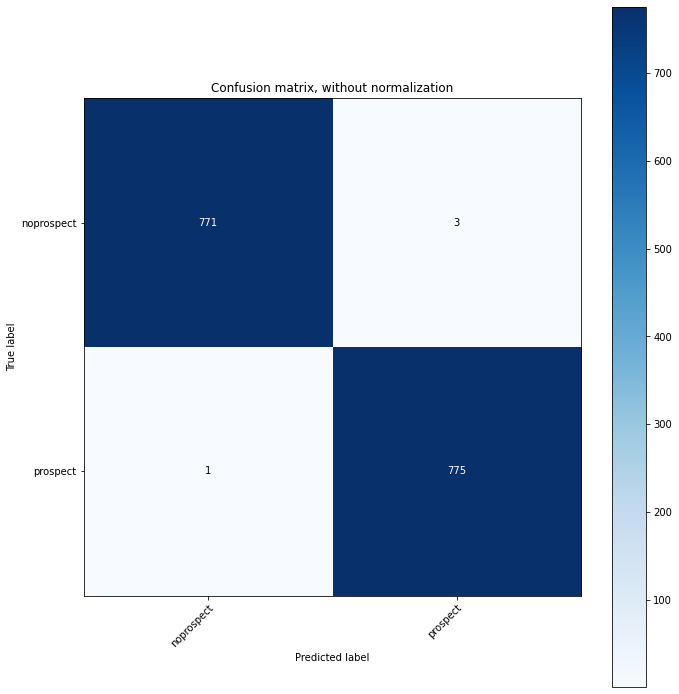

In [22]:
#Model config
width = 83 #32#83  --16
height= 83 #32#83  --16
layers = 7 #7 sat #6 drone
input_shape = (width, height, layers)
class_count = 2 #5
batch = 25 #25
epoch = 200
model_name =  'Drone_Tuned_BasicCNN'

class_names = dict((
(0,  'noprospect'),
(1, 'prospect'),
))

model = tf.keras.models.load_model(r"C:\Users\Gavin\Models\Thesis Models 2022\Drone\CNNBase\tuner\BasicCNN_FullDrone_tuned")
model.summary()

fulldataset_df = load_samples('BinFullDrone_dataset.csv')
gridsearch_df = pd.DataFrame(columns=['Modelname','Epoch','Batch_size','Accuracy','Precision','Recall','F1_Score','Cohens_kappa'])

train_df,test_df = train_test_split(fulldataset_df, test_size=0.2) #0.2
test_df,valid_df = train_test_split(test_df, test_size=0.5)
test_count = len(test_df)
print(test_count)

test_datagen = generator(samples=test_df,batch_size=batch_size,width=width,height=height,layers=layers,class_count=class_count)

#predictions against test dataset
predictions = model.predict_generator(generator=test_datagen, 
                        steps= test_count // batch,
                         verbose=1)

eval_generator = generator(samples=test_df,batch_size=1,width=width,height=height,layers=layers,class_count=class_count)
#determining labels
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)
#calcualte metrics
accuracy = accuracy_score(label_index, pred_index)
precision = precision_score(label_index, pred_index,average='macro')
recall = recall_score(label_index, pred_index, average='macro')
f1 = f1_score(label_index, pred_index,average='macro')
kappa = cohen_kappa_score(label_index, pred_index)
gridsearch_df=gridsearch_df.append({'Modelname':model_name,'Epoch':epoch,'Batch_size':batch,'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1_Score':f1,'Cohens_kappa':kappa},ignore_index=True)

#create a classification report and save a copy
clsf_report = pd.DataFrame(classification_report(y_true = label_index, y_pred = pred_index, output_dict=True)).transpose()
clsf_report.to_csv('ClassificationReport_'+ model_name + '.csv', index= True)

print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Recall: %f' % recall)
print('F1 score: %f' % f1)
print('Cohens kappa: %f' % kappa)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                          class_dict=class_names,model_name=model_name)

output_filename = 'basicCNN_sat16_bestmodel'
dir_name = './BasicCNN_Sat_16_5'
import shutil
shutil.make_archive(output_filename, 'zip', dir_name)


import zipfile
with zipfile.ZipFile('.zip', 'r') as zip_ref:
    zip_ref.extractall('')

#code to check the effects of upscaling the image - seems fine
width = 32 #32#83  --16
height= 32 #32#83  --16
layers = 7 #7 #6 drone

#check that a image tile opens 
img_filename = './SatBinDataset/noprospect/noprospect77_F.tif'
with rasterio.open(img_filename) as ds:
    tile = ds.read()
    tile = resize(tile, (layers,width,height),anti_aliasing=False)
    #tile = reshape_as_image(tile)

with rasterio.open('test3.tif',
    'w',
    driver='GTiff',
    height=tile.shape[1],
    width=tile.shape[2],
    count=tile.shape[0],
    dtype=tile.dtype,
    tile=ds.crs,
    nodata=None,
    transform=ds.transform
    ) as dst:
    dst.write(tile)
    
img_filename = 'test.tif'

tile = rasterio.open(img_filename)
plt.imshow(tile.read(7), cmap='pink')
plt.show()

print(tile.shape)

img_filename = 'test2.tif'

tile = rasterio.open(img_filename)
plt.imshow(tile.read(7), cmap='pink')
plt.show()

print(tile.shape)

img_filename = 'test3.tif'

tile = rasterio.open(img_filename)
plt.imshow(tile.read(7), cmap='pink')
plt.show()

print(tile.shape)